In [15]:
import csv
import os
from typing import List, AnyStr

import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import progressbar

In [16]:
def merge_arg_sort(value: np.ndarray) -> np.ndarray:
    # sourcery skip: hoist-if-from-if, use-assigned-variable
    n = len(value)
    index_temp = np.zeros((n,), np.int32)
    index = np.arange(n)

    h = 1
    status = 0
    while h <= n:
        for j in range(0, n - h, 2 * h):
            ls = j
            le = j + h - 1
            rs = j + h
            re = j + 2 * h - 1 if j + 2 * h - 1 < n - 1 else n - 1
            index_temp[ls:re + 1] = index[ls:re + 1]
            i1 = ls
            j1 = rs
            for k in range(ls, re + 1):

                if i1 <= le and j1 <= re:
                    if value[index_temp[j1]] == value[index_temp[i1]]: status = 0
                    if value[index_temp[j1]] < value[index_temp[i1]]: status = -1
                    if value[index_temp[j1]] > value[index_temp[i1]]: status = 1
                else:
                    if i1 > le: status = -1
                    if j1 > re: status = 1

                if status >= 0:
                    index[k] = index_temp[i1]
                    i1 += 1
                else:
                    index[k] = index_temp[j1]
                    j1 += 1
        h *= 2
    return index

In [17]:
def coincident(max_coincident=1):
    def coincident_decorator(func):
        def wrapper(*args, **kwargs):
            coincident_num = 1
            extreme = func(*args, **kwargs)
            while coincident_num < max_coincident:
                kwargs['eps'] += 1
                recalculated_extreme = func(*args, **kwargs)
                if len(extreme) == len(recalculated_extreme):
                    coincident_num += 1
                else:
                    extreme = recalculated_extreme
                    coincident_num = 1
            return extreme, kwargs['eps']

        return wrapper

    return coincident_decorator

In [18]:
@coincident(1)
def extremal_min(*, index: np.ndarray, eps: int) -> np.ndarray:
    n, extreme_min = len(index), []
    for k in range(n):
        for l in range(1, k + 1):
            if abs(index[k] - index[k - l]) <= eps:
                break
        else:
            extreme_min.append(index[k])
    return extreme_min

In [19]:
@coincident(1)
def extremal_max(*, index: np.ndarray, eps: int) -> np.ndarray:
    n, extreme_max = len(index), []
    for k in range(n):
        for l in range(1, (n - k)):
            if abs(index[k] - index[k + l]) <= eps:
                break
        else:
            extreme_max.append(index[k])
    return extreme_max

In [20]:
def plot_res(values, color_min=None, extreme_min=None, e_min=None, color_max=None, extreme_max=None, e_max=None):
    plt.figure(figsize=(15, 9))
    plt.plot(values)
    if extreme_min is not None:
        plt.scatter(extreme_min, values[extreme_min], marker='o', color=color_min, s=150,
                    label=f'eps={e_min}, elem={len(extreme_min)}')

    if extreme_max is not None:
        plt.scatter(extreme_max, values[extreme_max], marker='o', color=color_max, s=150,
                    label=f'eps={e_max}, elem={len(extreme_max)}')
    plt.legend()
    plt.show()

In [21]:
path = "/home/turilin/Documents/BitBucket/food-delivery/.temp_file/CardiogramTrain/training/training-a/a0019.wav"
y, sr = librosa.load(path, mono=True, duration=5)

print(f'Тип y: {type(y)} sr: {type(sr)}')
print(f'Размер аудиофайла: {y.shape}, {sr}')
print(f'Переменные: {y}, {sr}')

print(f'Аудио: {y}')

Тип y: <class 'numpy.ndarray'> sr: <class 'int'>
Размер аудиофайла: (110250,), 22050
Переменные: [ 0.0523224   0.06086368  0.06961291 ... -0.00733356 -0.00508187
 -0.00302001], 22050
Аудио: [ 0.0523224   0.06086368  0.06961291 ... -0.00733356 -0.00508187
 -0.00302001]


In [22]:
data = y[:]

[96537, 18998, 38454, 76903, 57748, 261, 5663, 102896, 83713, 25713, 45025, 64424, 90913, 14470, 72975, 51486]
[50707, 108585, 90125, 11473, 81, 64061, 102569, 25378, 83358, 44845, 57942, 5834, 77121, 19211, 96291, 38666]


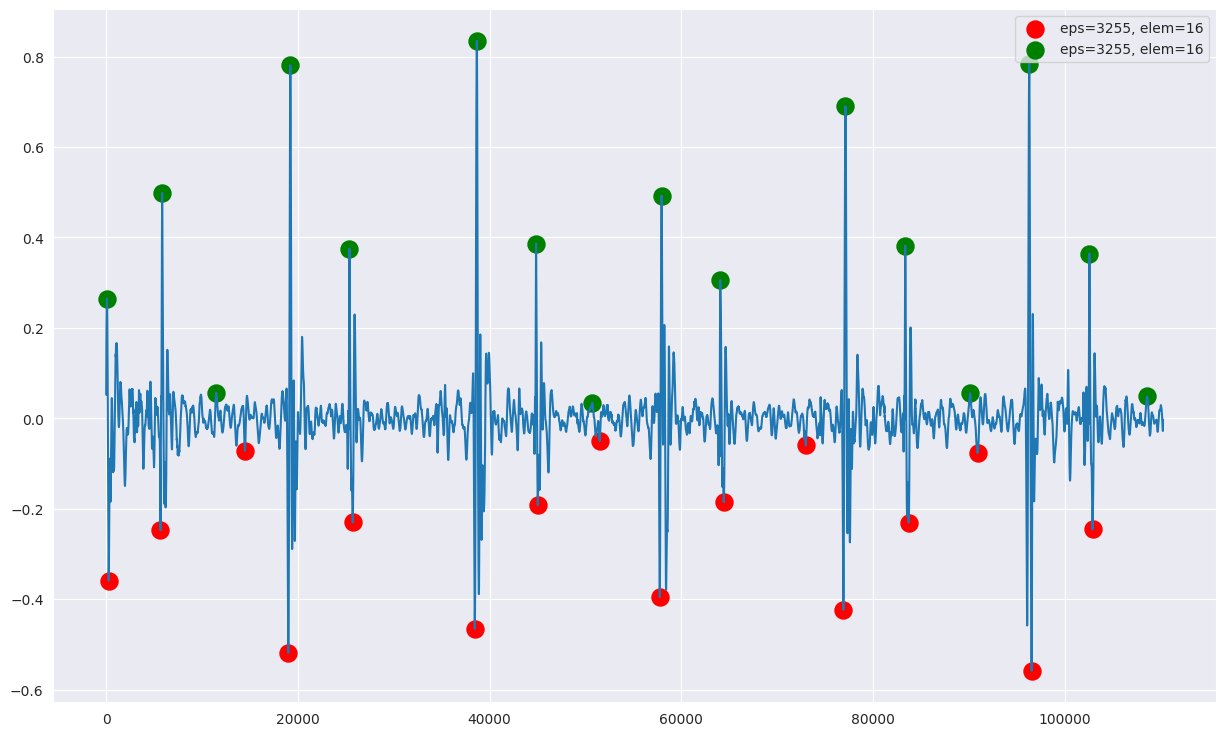

CPU times: user 1.27 s, sys: 79.8 ms, total: 1.35 s
Wall time: 1.2 s


In [23]:
%%time
indexes = np.argsort(data, kind='mergesort')
indexes_min, eps_min = extremal_min(index=indexes, eps=3255)
indexes_max, eps_max = extremal_max(index=indexes, eps=3255)
print(indexes_min)
print(indexes_max)
plot_res(values=data, color_min='r', extreme_min=indexes_min, e_min=eps_min, color_max='g', extreme_max=indexes_max,
         e_max=eps_max)

In [24]:
# parse normal and abnormal audio file path
def parse_audio_path(training_dir: str, syb_dir: str) -> List[AnyStr]:
    with open(f'{training_dir}/{syb_dir}/RECORDS-normal', 'r') as file_normal:
        normal = file_normal.read().strip().split('\n')
        normal = list(map(lambda elem: f'{elem.strip()}.wav/1', normal))

    with open(f'{training_dir}/{syb_dir}/RECORDS-abnormal', 'r') as file_abnormal:
        abnormal = file_abnormal.read().strip().split('\n')
        abnormal = list(map(lambda elem: f'{elem.strip()}.wav/0', abnormal))

    return normal + abnormal

In [25]:
def create_header(num_min_elem: int, num_max_elem: int):
    return [
        'filename',
        *[f'extreme_min{i}' for i in range(num_min_elem)],
        *[f'extreme_max{i}' for i in range(num_max_elem)],
        'label',
    ]

In [26]:
def extract_features(training_dir: str, syb_dir: str, path_file: str, audio_label: int, num_min_elem: int,
                     num_max_elem: int):
    audio_path = f'{training_dir}/{syb_dir}/{path_file}'
    values, _ = librosa.load(audio_path, mono=True, duration=5)

    _index = np.argsort(values, kind='mergesort')
    _index_min, _ = extremal_min(index=_index, eps=3255)
    _index_max, _ = extremal_max(index=_index, eps=3255)

    while len(_index_min) < num_min_elem:
        _index_min.append(None)

    while len(_index_max) < num_max_elem:
        _index_max.append(None)

    return [
        f'/{syb_dir}/{file_path}',
        *_index_min[:num_min_elem],
        *_index_max[:num_max_elem],
        audio_label
    ]

In [27]:
path = '../training/'
main_dir, main_syb_dir, _ = next(os.walk(path))
print(main_dir, main_syb_dir)

../training/ ['training-e', 'training-d', 'training-c', 'training-f', 'training-b', 'training-a']


In [28]:


buffer = []
count_audio = 0
count_rows = 0

path = '../training/'
main_dir, main_syb_dir, _ = next(os.walk(path))
print(main_dir, main_syb_dir)

# Создание заголовка для файла CSV.
header = create_header(20, 20)

with open('dataset_1.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(header)
    for _syb_dir in main_syb_dir:

        audio_paths = parse_audio_path(main_dir, _syb_dir)
        print(_syb_dir, end="  ")
        buffer_counter = 0

        for file_path in progressbar.progressbar(audio_paths):
            file, label = file_path.split('/')
            features = extract_features(main_dir, _syb_dir, file, label, 20, 20)
            buffer.append(features)
            if buffer:
                writer.writerows(buffer)
                buffer_counter += 1
            buffer = []

        print(f'Volume valid audio: {len(audio_paths)}, recorded rows in file: {buffer_counter}')
        count_audio += len(audio_paths)
        count_rows += buffer_counter

print(f'Analysis completed successfully, analyzed: {count_audio} files, written rows: {count_rows}')

  0% (0 of 2141) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

../training/ ['training-e', 'training-d', 'training-c', 'training-f', 'training-b', 'training-a']
training-e  

100% (2141 of 2141) |####################| Elapsed Time: 0:33:22 Time:  0:33:22
  0% (0 of 55) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Volume valid audio: 2141, recorded rows in file: 2141
training-d  

100% (55 of 55) |########################| Elapsed Time: 0:00:50 Time:  0:00:50
  0% (0 of 31) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Volume valid audio: 55, recorded rows in file: 55
training-c  

100% (31 of 31) |########################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (0 of 114) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Volume valid audio: 31, recorded rows in file: 31
training-f  

100% (114 of 114) |######################| Elapsed Time: 0:01:43 Time:  0:01:43
  0% (0 of 490) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Volume valid audio: 114, recorded rows in file: 114
training-b  

100% (490 of 490) |######################| Elapsed Time: 0:07:31 Time:  0:07:31
  0% (0 of 409) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Volume valid audio: 490, recorded rows in file: 490
training-a  

100% (409 of 409) |######################| Elapsed Time: 0:06:21 Time:  0:06:21


Volume valid audio: 409, recorded rows in file: 409
Analysis completed successfully, analyzed: 3240 files, written rows: 3240
